In [1]:
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard


%run utils.ipynb

2024-02-03 15:22:04.924384: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 15:22:04.953823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 15:22:04.953884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 15:22:04.954903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 15:22:04.960533: I tensorflow/core/platform/cpu_feature_guar

# GPU setup

In [2]:
gpu_setup()

Detected GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2024-02-03 15:22:07.038189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 15:22:07.068348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 15:22:07.068538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Data preprocessing

## Indicate the path of the dataset

In [3]:
data_dir = pathlib.Path('./dataset').with_suffix('')

## Split the data into Train and Validation sets

Here we used $80\%$ data for Training and $20\%$ for Validation. 


We also defined our input image sizes and each batch size.


$Image \, Size = (160, 160)$


$Batch \, Size = 32$

In [4]:
# Introduce the Batch size and Image size
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
CHANNELS = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

In [5]:
# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 354 files belonging to 15 classes.


Using 284 files for training.


2024-02-03 15:22:08.970053: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 15:22:08.970550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 15:22:08.970657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 354 files belonging to 15 classes.
Using 70 files for validation.


## Check the labels and get number of classes

We need the number of the classes for our last ***Dense*** layer and we use each class name as the label for the instances in that class.

In [7]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(class_names)

['AliDaei', 'AlirezaBeiranvand', 'BaharehKianAfshar', 'BahramRadan', 'HomayoonShajarian', 'JavadRazavian', 'MehranGhafoorian', 'MohamadEsfehani', 'MohsenChavoshi', 'NazaninBayati', 'RezaAttaran', 'SaharDolatshahi', 'SeyedJalalHosseini', 'SogolKhaligh', 'TaranehAlidoosti']


## Examine some of the training images

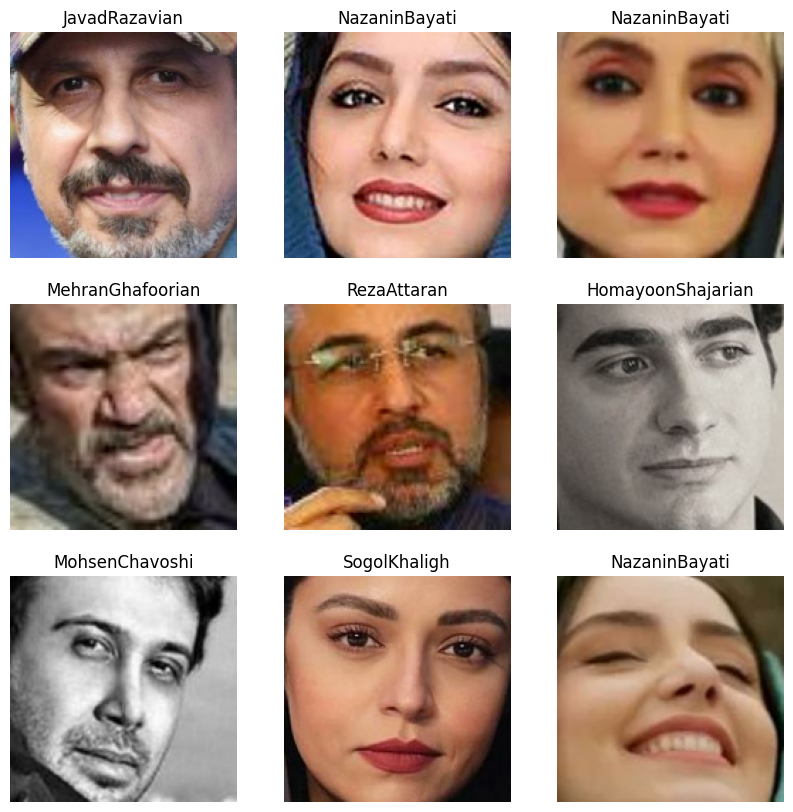

In [8]:
plot_images(train_ds, class_names, 3, 3)

## Examine each batch in training dataset

We can examine the shapes of the image and label batches in the train_ds. This can be helpful for understanding the dimensions of the data and ensuring it matches our expectations or requirements for model training.

In [9]:
batch_examination(train_ds)

Each batch image shape: (32, 160, 160, 3)
Each batch label shape: (32,)


## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer Learning with ResNet architecture and ImageNet weights

## Data Preprocessing for transform learning 

### Data augmentation

Here we can use different augmentation methods and examine which one can help us to reduce high variance.

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),  # Increase rotation angle
    layers.RandomZoom(0.1),      # Increase zoom factor
    layers.RandomContrast(0.1),  # Add contrast adjustment
    layers.RandomBrightness([-0.2, 0.2]),
    layers.RandomTranslation(0.1, 0.1),
  ]
)

#### Visualize all augmentations on one image

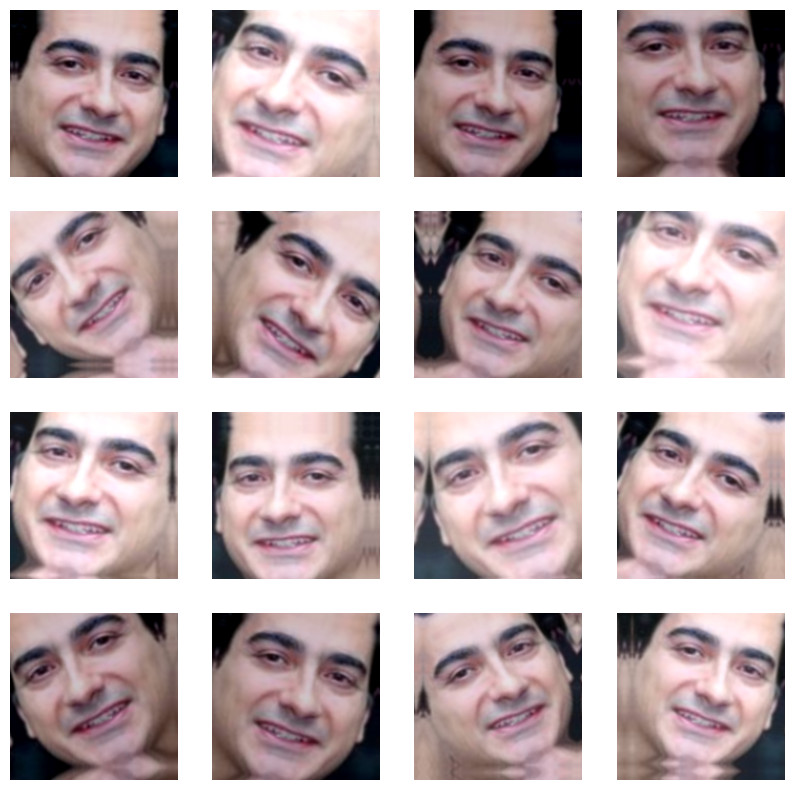

In [12]:
plot_augmentations(train_ds, data_augmentation, 4, 4)

#### Visualize augmentations on different images

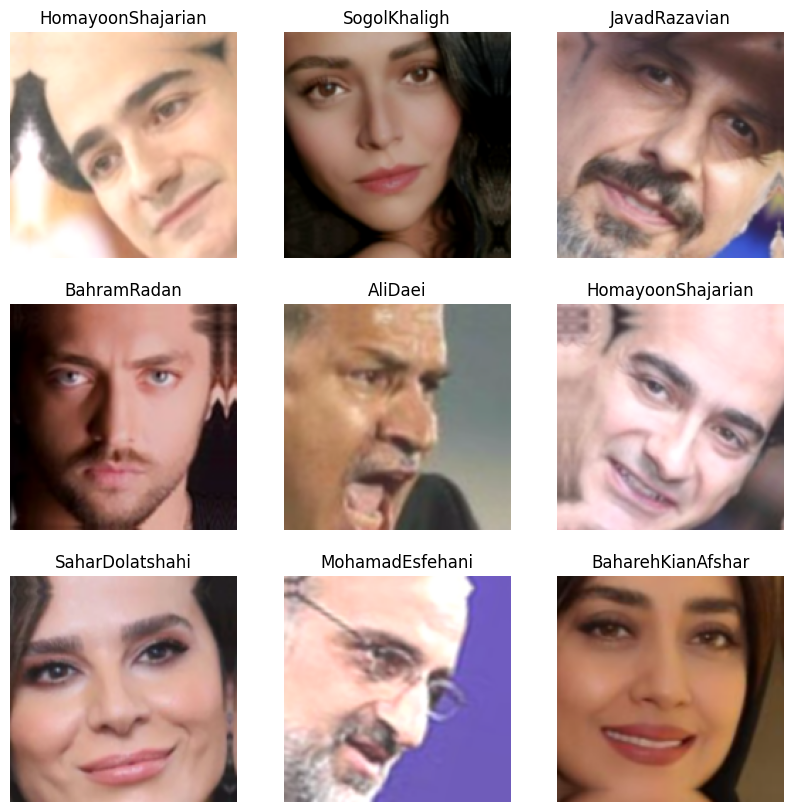

In [13]:
plot_images(train_ds, class_names, 3, 3, data_augmentation)

### Rescale pixel values

In [14]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

## Building and Training the model

### Create the base model from the pre-trained convnets

In [15]:
base_model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### Feature Extraction

In [16]:
base_model.trainable = False
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

### Build the model architecture 

We build the model architecture using the base model and our classification layer

In [17]:
model = Sequential([
  data_augmentation,
  Lambda(preprocess_input, input_shape=IMG_SHAPE),
  
  base_model,
  layers.GlobalAveragePooling2D(),

  layers.Dropout(0.5),
  layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
  layers.Dense(NUM_CLASSES, name="outputs")
])

In [18]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [19]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-02-03 15:22:39.745057: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-03 15:22:41.412917: I external/local_xla/xla/service/service.cc:168] XLA service 0x74eb306648f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 15:22:41.412962: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-02-03 15:22:41.419230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706961161.486869  183334 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 9s 421ms/step - loss: 5.9030 - accuracy: 0.0951 - val_loss: 4.9995 - val_accuracy: 0.1429
Epoch 2/50
9/9 [==============================] - 1s 71ms/step - loss: 4.8369 - accuracy: 0.1972 - val_loss: 4.4183 - val_accuracy: 0.3000
Epoch 3/50
9/9 [==============================] - 1s 71ms/step - loss: 4.3633 - accuracy: 0.2500 - val_loss: 4.0636 - val_accuracy: 0.2571
Epoch 4/50
9/9 [==============================] - 1s 70ms/step - loss: 4.0194 - accuracy: 0.3099 - val_loss: 3.7467 - val_accuracy: 0.3571
Epoch 5/50
9/9 [==============================] - 1s 71ms/step - loss: 3.7946 - accuracy: 0.3169 - val_loss: 3.4482 - val_accuracy: 0.3429
Epoch 6/50
9/9 [==============================] - 1s 71ms/step - loss: 3.4748 - accuracy: 0.3732 - val_loss: 3.2414 - val_accuracy: 0.4143
Epoch 7/50
9/9 [==============================] - 1s 72ms/step - loss: 3.2017 - accuracy: 0.4049 - val_loss: 3.0544 - val_accuracy: 0.4000
Epoch 8/50
9/9 [=====================

### Plot the results

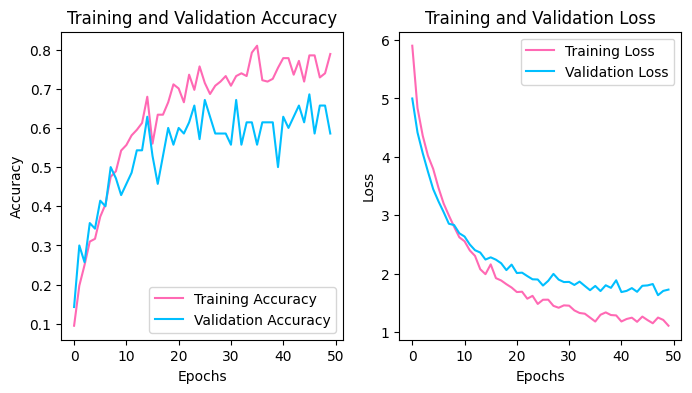

In [20]:
plot_loss_accuracy(history, epochs)

# Our own Custom Model

## Data Preprocessing for our model

### Data augmentation

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),  # Increase rotation angle
    layers.RandomZoom(0.1),      # Increase zoom factor
    layers.RandomContrast(0.1),  # Add contrast adjustment
    layers.RandomBrightness(0.1),
  ]
)

#### Visualize all augmentations on one image

In [ ]:
plot_augmentations(train_ds, data_augmentation, 4, 4)

#### Visualize augmentations on different images

In [ ]:
plot_images(train_ds, class_names, 3, 3, data_augmentation)

## Building and Training the model

### Build the model architecture

This time we build the whole model by ourselves. This model includes all the **convolution layers** for feature extraction and also the **dense layers** for classification.

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=IMG_SHAPE),

  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(NUM_CLASSES, name="outputs")

])

In [17]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [18]:
tensorboard_callback = TensorBoard(log_dir="./logs2")

epochs = 100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/100


9/9 [==============================] - 2s 28ms/step - loss: 5.9831 - accuracy: 0.0880 - val_loss: 5.0221 - val_accuracy: 0.1000
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 4.5569 - accuracy: 0.1162 - val_loss: 4.1042 - val_accuracy: 0.1000
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: 3.8745 - accuracy: 0.1162 - val_loss: 3.6630 - val_accuracy: 0.1000
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 3.5118 - accuracy: 0.1162 - val_loss: 3.3883 - val_accuracy: 0.1000
Epoch 5/100
9/9 [==============================] - 0s 16ms/step - loss: 3.2705 - accuracy: 0.1162 - val_loss: 3.1875 - val_accuracy: 0.1000
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 3.1143 - accuracy: 0.1162 - val_loss: 3.0643 - val_accuracy: 0.1000
Epoch 7/100
9/9 [==============================] - 0s 16ms/step - loss: 3.0079 - accuracy: 0.1162 - val_loss: 2.9657 - val_accuracy: 0.1143
Epoch 8/100
9/9 [===============

### Plot the results

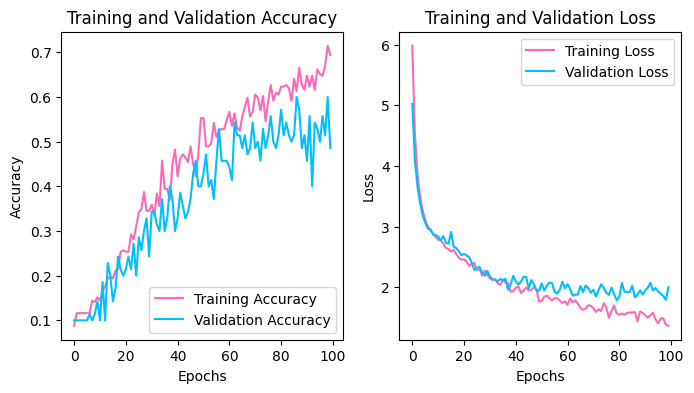

In [19]:
plot_loss_accuracy(history, epochs)

## Save the Custom model

In [21]:
model.save('custom_model.keras')

# Transfer Learning using our own model

Here we use our face_recognition (which we trained on another dataset) model architecture and weights for transfer learning.

## Data preprocessing for transform learning

### Data augmentation

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomTranslation(0.1, 0.1),
  ]
)

## Building and Training the model

### Create the base model from our pre-trained model

In [12]:
base_model = keras.models.load_model('./face_recognition.keras')
base_model.trainable = False

In [13]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 80, 80, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                 

### Build the model architecture 

We build the model architecture using the base model and our classification layer

In [14]:
base_layers = tf.keras.Sequential(base_model.layers[:-2])

model = Sequential([
  data_augmentation,

  base_layers,

  layers.Dropout(0.5),
  layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
  layers.Dense(NUM_CLASSES, name="outputs"),
])

In [15]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [16]:
tensorboard_callback = TensorBoard(log_dir="./logs")

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback],
)

Epoch 1/100


2024-02-03 15:21:06.594264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-03 15:21:07.508747: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a408c6375b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 15:21:07.508801: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-02-03 15:21:07.514667: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706961067.596403  176369 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - 4s 66ms/step - loss: 6.1739 - accuracy: 0.0845 - val_loss: 4.9591 - val_accuracy: 0.1143
Epoch 2/100
9/9 [==============================] - 0s 15ms/step - loss: 4.6975 - accuracy: 0.1268 - val_loss: 4.3541 - val_accuracy: 0.1857
Epoch 3/100
9/9 [==============================] - 0s 15ms/step - loss: 4.3102 - accuracy: 0.1268 - val_loss: 4.0837 - val_accuracy: 0.3429
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 4.1063 - accuracy: 0.2254 - val_loss: 3.8017 - val_accuracy: 0.2429
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 3.8294 - accuracy: 0.2289 - val_loss: 3.5766 - val_accuracy: 0.2714
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 3.5393 - accuracy: 0.2852 - val_loss: 3.3654 - val_accuracy: 0.3286
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 3.4644 - accuracy: 0.2958 - val_loss: 3.1319 - val_accuracy: 0.4000
Epoch 8/100
9/9 [===============

### Plot the results

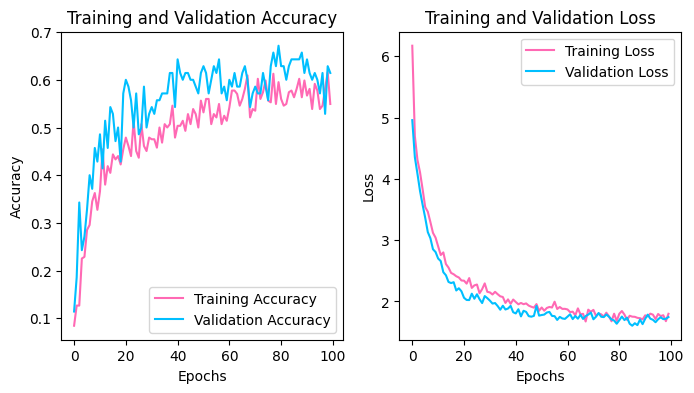

In [17]:
plot_loss_accuracy(history, epochs)

## Save the model

In [ ]:
model.save("custom_transer.keras")